In [7]:
from data import LipsyncDataset
import torch
from torch import nn
from data import AudioMFCC, CustomMFCC
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
from torch import Tensor
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
import torchaudio.functional as F

In [8]:
dataset = LipsyncDataset('../data/lipsync.parquet')

In [78]:
#audio_raw = dataset[0]['audio']
waveform, sr = torchaudio.load("hello_16000.wav")
rwaveform = waveform #torchaudio.functional.resample(waveform, sr, 16000)

audio_raw = rwaveform.reshape([-1])
audio_mfcc = AudioMFCC()({ 'audio': audio_raw, 'visemes': [] })['audio'][:13, :]

In [79]:
audio_raw.shape, audio_mfcc.shape, (audio_raw.shape[0] / 16000 - 25e-3)/ (10e-3)

(torch.Size([60604]), torch.Size([13, 377]), 376.275)

In [80]:
def plot_spectrogram(specgram, title=None, xlabel="time", ylabel="freq"):
    _, ax = plt.subplots(1, 1)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [81]:
def mfcc(samples, audio_rate=16000, num_mels=13, window_time=25e-3, hop_time=10e-3):
    window_length = round(window_time * audio_rate)
    hop_length = round(hop_time * audio_rate)
    melkwargs = {
        "n_fft": window_length,
        "win_length": window_length,
        "hop_length": hop_length,
        "n_mels": num_mels,
        "center": False,
    }
    custommfcc = CustomMFCC(sample_rate=audio_rate, n_mfcc=num_mels, melkwargs=melkwargs)
    ms = custommfcc.MelSpectrogram.mel_scale
    a = custommfcc(samples)
    d = np.array([0.5, 0.5, -0.5, -0.5])
    x = a.numpy()
    delta_a = np.apply_along_axis(np.convolve, axis=1, arr=x, v=d, mode='same')
    # Stack everything
    #return torch.cat((a, torch.tensor(delta_a))).to(torch.float)
    return a.to(torch.float)


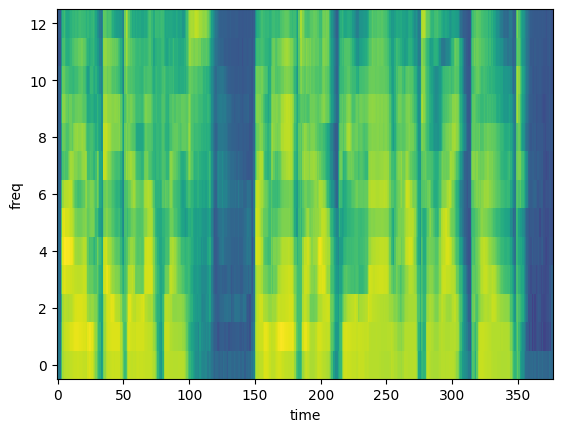

In [82]:
plot_spectrogram(mfcc(audio_raw))

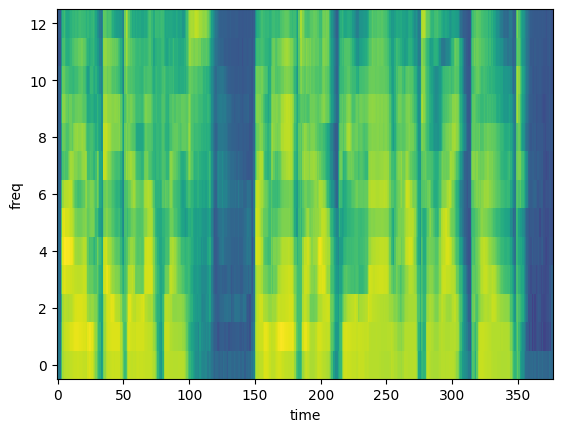

In [83]:
plot_spectrogram(audio_mfcc)

In [84]:
(mfcc(audio_raw) - audio_mfcc).sum()

tensor(0.)

In [85]:
import torch
torch.hann_window(5)

tensor([0.0000, 0.3455, 0.9045, 0.9045, 0.3455])

In [104]:
def mfcc2(samples, audio_rate=16000, num_mels=13, window_time=25e-3, hop_time=10e-3):
    window_length = round(window_time * audio_rate)
    fft_length = window_length // 2 + 1
    hop_length = round(hop_time * audio_rate)
    n = len(range(0, samples.shape[0] - window_length, hop_length))
    a = torch.zeros(num_mels, n)
    melbank = F.melscale_fbanks(fft_length, 0.0, audio_rate / 2.0, num_mels, audio_rate, None, 'htk')
    torch.save({ 'test': melbank }, 'melbank.pt')
    hann = torch.hann_window(window_length, periodic=True)

    def ms(x, debug=False):
        # Window with hann window
        #print(f"x = {x.shape} {x}")
        wx = x * hann
        # Do FFT, then do |fft|^2 to get power
        fx = torch.fft.fft(wx).abs().pow(2.0)[:201]
        if debug:
            print(f"pwr = {fx}");
        # fx is shape [201]
        # melbank is shape [201, 13]
        mx = torch.matmul(fx, melbank)
        # mx is [13]
        return mx.unsqueeze(1)
    
    def adb(x):
        return torch.log10(torch.clamp(x, min=1e-10)) * 10.0

    for i in range(n):
        offset = i * hop_length
        slc = torch.zeros(window_length)
        slc[:min(window_length, samples.shape[0] - offset)] = samples[offset:offset + window_length]
        msx = ms(slc, False)
        slc_m = adb(msx)
        a[:, i] = slc_m[:, 0]

    return a

#mfcc2(audio_raw)[:, 50], audio_mfcc[:, 50]
mfcc2(audio_raw)[:, 0], audio_mfcc[:, 0]

(tensor([-92.2079, -98.8044, -90.1517, -89.8466, -92.6804, -89.9067, -90.7464,
         -89.3316, -87.2600, -86.3742, -86.7014, -87.2689, -85.9339]),
 tensor([-92.2079, -98.8044, -90.1517, -89.8466, -92.6804, -89.9067, -90.7464,
         -89.3316, -87.2600, -86.3742, -86.7014, -87.2689, -85.9339]))

90

In [70]:
y = torch.fft.fft(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8]))
y.abs().pow(2.0)

tensor([1296.0000,  109.2548,   32.0000,   18.7452,   16.0000,   18.7452,
          32.0000,  109.2548])

In [71]:
fb = F.melscale_fbanks(400, 0.0, 8000.0, 13, 16000, None, 'htk')

In [72]:
fb

tensor([[-0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1452, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2905, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0280],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0140],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [91]:
torch.hann_window(10)

tensor([0.0000, 0.0955, 0.3455, 0.6545, 0.9045, 1.0000, 0.9045, 0.6545, 0.3455,
        0.0955])

In [150]:
25e-3*16e3

400.0